In [1]:
import pandas as pd
import psycopg2 as pg
import pandas.io.sql as psql
import datetime as dt
import numpy as np
import scipy.stats as stats
from ukpostcodeutils import validation
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sbn
import collections
from functools import reduce
#from collections import OrderedDict
%matplotlib inline
# pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = 'raise'

In [2]:
def dict_from_db():
    """
    Returns a dict of dataframes from the database tables
    which are populated by the study application
    """
    conn = pg.connect("dbname='carlplaying' user='drcjar' password='drcjar_is_not_fake'")

    cursor = conn.cursor()
    cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
    e = cursor.fetchall()

    table_name_list = [i[0] for i in e]

    select_template = 'SELECT * FROM {table_name}'
    frames_dict = {}
    for tname in table_name_list:
        query = select_template.format(table_name = tname)
        frames_dict[tname] = pd.read_sql(query, conn)
    return frames_dict

def notepisodes():
    """
    Returns a list of episode_ids that are not in fact episodes for analysis purposes
    e.g patients who have not yet been interviewed
    *** This list is made in the quality check notebook ***
    """
    notepisodes = []

    with open("notepisodes.txt", "r") as f:
        for line in f:
            notepisodes.append(int(line.strip()))
    return notepisodes

def dist_from_centre(x): 
    """
    Calculate distance from patients GP practice to their
    recruitment centre.
    """
    return geopy.distance.vincenty(x.gp_coords, x.centre_coords).km

In [3]:
ddf = dict_from_db() # dict of dataframes
ne = notepisodes() # not episodes

In [4]:
def study_df(df):
    """
    Makes the main study dataframe from our occupational dataframe
    """
    df = df.loc[:,['patient_id', 'soc_job_ft', 'soc_job_fk_id', 'id', 'job_tasks', 
                   'start_year', 'end_year','employer_output', 'address', 'company_name',
                   'working_area_ft']].copy() # e.g for debugging
    df = df[~df.patient_id.isin(notepisodes())] # discard not episodes
    
   # df = df[~df.patient_id.isin([24, 30, 202])] # exclude isle of man as don't have postcode 
                                                # centroid at present n=3,
                                                # all from centre 8
    
    # we fix above isle of man issue with these details
    """
    24, IM5 1HU, 54.2211357,-4.6912903

    30, IM2 3TD 54.1693712,-4.4772768

    202, IM2 7EA 54.171227,-4.492851
    
    """
    
    # add participant_id
    pid_lookup = ddf['ipfjes_demographics'].loc[:,['patient_id', 'hospital_number']].copy()
    pid_lookup.index = pid_lookup['patient_id']
    pid_lookup = pid_lookup['hospital_number'].to_dict()
    df['participant_id'] = df['patient_id'].map(pid_lookup)
    
    # add participant type
    pt_lookup = ddf['ipfjes_studyparticipantdetails'].loc[:,['episode_id', 'participant_type']].copy()
    pt_lookup.index = pt_lookup['episode_id']
    pt_lookup = pt_lookup['participant_type'].to_dict()
    df['case'] = df['patient_id'].map(pt_lookup)
    
    # add job titles
    # stick a NaN in missing soc_job_ft and replace with a job title from our lookup
    df = df.replace('', np.nan) 
    job_lookup = ddf['ipfjes_socjob'].loc[:,['id','name']].copy()
    job_lookup.index = job_lookup['id']
    job_lookup = job_lookup['name'].to_dict()
    df['jt'] = df['soc_job_fk_id'].map(job_lookup)
    df.soc_job_ft.fillna(df.jt, inplace=True)
    del df['jt']
    del df['soc_job_fk_id']
    
    # add job duration
    df['duration'] = df.end_year.astype(int) - df.start_year.astype(int) 
    
    # add soc 90 code
    soc90_lookup = ddf['ipfjes_soccode'].loc[:,['soc90', 'title']].copy()
    soc90_lookup.index = soc90_lookup['title']
    soc90_lookup = soc90_lookup['soc90'].to_dict()
    df['soc90'] = df.soc_job_ft.map(soc90_lookup)
    
    # add soc 2000 code
    soc2000_lookup = ddf['ipfjes_soccode'].loc[:,['soc2000', 'title']].copy()
    soc2000_lookup.index = soc2000_lookup['title']
    soc2000_lookup = soc2000_lookup['soc2000'].to_dict()
    df['soc2000'] = df.soc_job_ft.map(soc2000_lookup)

    # add socioeconomic code
    ssec_lookup = pd.read_csv('nssec/nssecderivationtablessoc2000_tcm77-264822.csv') 
    # nb we're using sheet fm2kac even though we don't know what it means. we should know.
    ssec_lookup = ssec_lookup[['SOC2000', 'ssec']] 
    # simplified socioeconomic classification using soc2000
    ssec_lookup.index = ssec_lookup['SOC2000']
    ssec_lookup = ssec_lookup['ssec'].to_dict()
    df['ssec'] = df.soc2000.map(ssec_lookup)

    # add dob
    dob_lookup = ddf['ipfjes_demographics'].loc[:,['hospital_number', 'date_of_birth']].copy()
    dob_lookup.index = dob_lookup['hospital_number']
    dob_lookup = dob_lookup['date_of_birth'].to_dict()
    df['dob'] = df.participant_id.map(dob_lookup)
    
    # add age in years and agegroup
    df['age'] = ((dt.datetime.now() - pd.to_datetime(df.dob)).dt.days / 365).astype(int)
    df['agegroup'] = pd.cut(df.age, range(25,100,5), 
                    labels=[
                        '25 to 29',
                        '30 to 34',
                        '35 to 39',
                        '40 to 44',
                        '45 to 49',
                        '50 to 54',
                        '55 to 59',
                        '60 to 64',
                        '65 to 69',
                        '70 to 74',
                        '75 to 79',
                        '80 to 84',
                        '85 to 90',
                        '90 to 94'],
                    right=False) 
    
    # add yob
    df['dob'] = pd.to_datetime(df.dob)
    df['yob'] = df['dob'].dt.strftime('%Y')
    
    # add ethnicity
    eth_lookup = ddf['ipfjes_demographics'].loc[:,['patient_id', 'ethnicity_ft']].copy()
    eth_lookup.index = eth_lookup['patient_id']
    eth_lookup = eth_lookup['ethnicity_ft'].to_dict()
    df['ethnicity'] = df.patient_id.map(eth_lookup)
    
    # add smoking
    es_lookup = ddf['ipfjes_smokinghistory'].loc[:,['episode_id', 'ever_smoked']].copy()
    es_lookup.index = es_lookup['episode_id']
    es_lookup = es_lookup['ever_smoked'].to_dict()
    df['ever_smoked'] = df.patient_id.map(es_lookup)
    
    cs_lookup = ddf['ipfjes_smokinghistory'].loc[:,['episode_id', 'current_smoker']].copy()
    cs_lookup.index = cs_lookup['episode_id']
    cs_lookup = cs_lookup['current_smoker'].to_dict()
    df['current_smoker'] = df.patient_id.map(cs_lookup)
    
    # to calculate pack years we must consider ex-smokers and current smokers separately
    age_lookup = df.loc[:,('patient_id','age')].copy()
    age_lookup.index = age_lookup['patient_id']
    age_lookup = age_lookup['age'].to_dict()

    es = ddf['ipfjes_smokinghistory'][(ddf['ipfjes_smokinghistory']['ever_smoked'] == 'Yes') & (ddf['ipfjes_smokinghistory']['current_smoker'] == 'No')].copy() # ex-smokers
    
    es['years_smoked'] = es['stop_smoking_age'].astype('int') - es['start_smoking_age'].astype('int')
    es.cigarettes_per_day = es.cigarettes_per_day.fillna(0) # because not all folks smoke cigarettes
    es.cigarettes_per_day = es['cigarettes_per_day'].replace('',0)
    es['pack_years'] = (es['cigarettes_per_day'].astype(float) / 20) * es['years_smoked']

    cs = ddf['ipfjes_smokinghistory'][ddf['ipfjes_smokinghistory']['current_smoker'] == 'Yes'].copy() # current smokers
    cs['age'] = cs['episode_id'].map(age_lookup)
    cs['years_smoked'] = cs['age'] - cs['start_smoking_age'].astype('int')
    cs.cigarettes_per_day = cs.cigarettes_per_day.fillna(0) # because not all folks smoke cigarettes
    

    
    cs['pack_years'] = (cs['cigarettes_per_day'].astype(int) / 20) * cs['years_smoked']
    del cs['age']
    # n.b let's populate a cigarettes per day equivalent in the app later as a workaround
    # using https://www.smokingpackyears.com/
    # Lose tobacco estimates that 25 grams (1oz) has been approximated to the equivalent of 50 cigarettes.
    
    packyears = pd.concat([es, cs])
    packyears.loc[:,['episode_id','pack_years']]
    packyears.index = packyears['episode_id']
    packyears = packyears['pack_years'].to_dict()
    df['packyrs'] =  df['patient_id'].map(packyears)
    
    # add centre_id
    # note that we encode centre id in first two digits of hospital number
    # note patient_id == episode_id in the demographics table
    df['centre'] = df['participant_id'].str[:2].astype(int) 
    
    # add gp long/lat
    centroids = pd.read_csv('ONS_Postcode_Directory_Latest_Centroids.csv', usecols=[0,1,3,4,5,12,13,44])
    centroids['pcd'] = centroids['pcd'].str.strip()
    centroids['pcd'] = centroids['pcd'].str.replace(" ","")
    centroids['pcd'] = centroids['pcd'].str.replace("  ","")
    
    gp_lookup = ddf['ipfjes_demographics'][ddf['ipfjes_demographics']['contact_details'].notna()].copy()
    # quality issues with gp postcode addressed in quality notebook
    gp_lookup = gp_lookup[['patient_id', 'contact_details']]
    gp_lookup.index = gp_lookup.patient_id
    gp_lookup['contact_details'] = gp_lookup['contact_details'].str[-8:]
    gp_lookup['contact_details'] = gp_lookup['contact_details'].str.strip()
    gp_lookup['contact_details'] = gp_lookup['contact_details'].str.replace(",","")
    gp_lookup['contact_details'] = gp_lookup['contact_details'].str.replace(" ","")
    gp_lookup['contact_details'] = gp_lookup['contact_details'].str.replace("  ","")
    gp_lookup = gp_lookup[gp_lookup['contact_details'].map(lambda x: validation.is_valid_postcode(str(x)))]
    gp_lookup.columns = ['patient_id', 'pcd']
    gp_lookup_centroids = pd.merge(gp_lookup, centroids, on='pcd')
    gp_lookup_centroids['gp_coords'] = list(zip(gp_lookup_centroids.Y, gp_lookup_centroids.X))
    
    gp_lookup_centroids = gp_lookup_centroids[['patient_id', 'gp_coords']].copy()
    gp_lookup_centroids.index = gp_lookup_centroids['patient_id']
    gp_lookup_centroids = gp_lookup_centroids['gp_coords'].to_dict()
    df['gp_coords'] = df['patient_id'].map(gp_lookup_centroids)

    # add hospital long/lat
    trustpcds = pd.read_csv('trustpcd.csv')
    trustpcds['pcd'] = trustpcds['pcd'].str.strip()
    trustpcds['pcd'] = trustpcds['pcd'].str.replace(" ","")
    trustpcds_centroids = pd.merge(trustpcds, centroids, on='pcd')
    trustpcds_centroids['centre_coords'] = list(zip(trustpcds_centroids.Y, trustpcds_centroids.X))
    
    tp_lookup_centroids = trustpcds_centroids[["Centre ID", "centre_coords"]].copy()
    tp_lookup_centroids.index = tp_lookup_centroids['Centre ID']
    tp_lookup_centroids = tp_lookup_centroids['centre_coords'].to_dict()
    df['centre_coords'] = df['centre'].map(tp_lookup_centroids)
    
    # fixes missing isle of man gp long/lats
    isle_of_man_gp_coords_lookup = {24:"(54.2211357,-4.6912903)",
                      30:"(54.1693712,-4.4772768)",
                      202:"(54.171227,-4.492851)"}
    mask = df['gp_coords'].astype(str) == "(nan, nan)"
    a = df[mask]
    b = df[~mask]
    a = a.copy()
    a.loc[:,'gp_coords'] = a.loc[:,'patient_id'].map(isle_of_man_gp_coords_lookup)
    df = pd.concat([a,b])

    df['distfromcentre'] = df.apply(dist_from_centre, axis=1)
    
    # add ct
    ct_lookup = ddf['ipfjes_ctandbiopsy'].loc[:,['episode_id', 'ct_findings']].copy()
    ct_lookup.index = ct_lookup['episode_id']
    ct_lookup = ct_lookup['ct_findings'].to_dict()
    df['ct'] = df.patient_id.map(ct_lookup)

    # add bx
    bx_lookup = ddf['ipfjes_ctandbiopsy'].loc[:,['episode_id', 'biopsy_findings']].copy()
    bx_lookup.index = bx_lookup['episode_id']
    bx_lookup = bx_lookup['biopsy_findings'].to_dict()
    df['bx'] = df.patient_id.map(bx_lookup)
    
    # add fhx scarring lung dis
    fhx_lookup = ddf['ipfjes_bloodrelationhistory'].loc[:,['episode_id','scarring']].copy()
    fhx_lookup.index = fhx_lookup['episode_id']
    fhx_lookup = fhx_lookup['scarring'].to_dict()
    df['fhx'] = df.patient_id.map(fhx_lookup)

    # add scarring drugs
    drugs = ddf['ipfjes_scarringdrugs'].loc[:,['episode_id', 'amiodarone', 'flecainade', 'nitrofurantoin', 'azathioprine', 'gefitinib', 'ifosfamide', 'melphalan', 'rituximab']].copy()
    drugs['patient_id'] = drugs['episode_id']
    del drugs['episode_id']
    df = pd.merge(df, drugs , on='patient_id').copy()
    
    # add mmrc dyspnoea
    mmrc = ddf['ipfjes_dyspnoea'].loc[:,['episode_id', 'breathless', 'short_of_breath', 'slower_than_most', 'stops_for_breath', 'dressing_undressing']].copy()
    mmrc.columns = ['patient_id', 'mrc0', 'mrc1', 'mrc2', 'mrc3', 'mrc4']
    df = pd.merge(df, mmrc, on='patient_id').copy()
    
    # symptoms leading to diagnosis
    pc = ddf['ipfjes_diagnosishistory'].loc[:,['episode_id','breathlessness', 'cough', 'incidental', 'incidental_desc', 'other']].copy()
    pc.columns = ['patient_id', 'pc_sob', 'pc_cough', 'pc_incidental', 'pc_incidental_desc', 'pc_other']
    df = pd.merge(df, pc, on='patient_id').copy()

    # add comments
    comments = ddf['ipfjes_studyparticipantdetails'].loc[:,['episode_id', 'comments']].copy()
    comments['patient_id'] = comments['episode_id']
    del comments['episode_id']
    df = pd.merge(df, comments, on='patient_id').copy()

    # ddf['ipfjes_pastmedicalhistory'] # appears has special either name of condition with id - see how did for job titles
    # also need to flatten / analyze separately

    # let 'yes' 'no' be bool, then we can have an mmrc score among other things
    df = df.replace({'Yes': True, 'No': False})
    df['mrc_score'] = df.loc[:,['mrc1', 'mrc2', 'mrc3', 'mrc4']].sum(axis=1)
    
    return df

In [5]:
df = study_df(ddf['ipfjes_occupationalhistory']) # main study dataframe

/home/drcjar/anaconda3/envs/ipfjes/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
def asbexposed():
    """
    Returns a df of at asbestos exposed SOC2000 codes from David Coggon
    Definition of asbestos-exposed job groups: 
    those groups with significantly elevated PMR for 
    pleural cancer during the whole period of 1979-80, 1982-2010
    provided by email
    """
    df = pd.read_csv('coggon_soc2000_meso_pmr.csv')
    df.soc2000 = df.soc2000.astype(str)
    return df

def asbexposed2():
    """
    Returns a df of at asbestos exposed SOC1990 codes from Julian Peto case-control
    study paper.
    
    Table 2.3.1
    Highest mesothelioma proportional mortality ratios (PMRs) for males aged
    16-74 in Great Britain, 1991-2000 (PMR>200 with lower confidence interval >100 and
    based on more than 30 deaths)
    
    Uses Mesothelioma proportional mortality ratios (PMRs) for males aged 16-74 
    in Great Britain by Standard Occupational Classification (1990) unit group, 1991-2000 
    data release.
    """
    df = pd.read_excel('./data/occ80007.xls', skiprows=2) 
    df = df[(df.Lower > 100) & (df.Deaths > 30) & (df.PMR > 200)]
    df['soc1990'] = df['SOC Occupation Code'].astype(str)
    return df

In [7]:
ae = asbexposed() # asbestos exposed soc2000 codes dataframen (coggan)
ae2 = asbexposed2() # asbestos exposed soc1990 codes dataframe (peto)

In [8]:
def clean_list(messylist):
    """
    Cleans a list containing ranges by expanding ranges e.g 1-4 becomes 1,2,3,4. 
    like the ones we have in table 2.3.2 www.hse.gov.uk/research/rrpdf/rr696.pdf
    """

    nums = []
    expandnums = []

    messylist = messylist.split(",")
    messylist = [s.strip() for s in messylist]

    for s in messylist:
        if '-' in s:
            s = s.split("-")
            s = [int(i) for i in s]
            expandnums.append(range(s[0], s[1]+1))
        else:
            nums.append(int(s))
        
    expandnums = [item for sublist in expandnums for item in sublist]
    cleanlist = nums + expandnums
    cleanlist.sort()
    return cleanlist

def makejobclassification():
    """
    makes a jobgroupclassification that maps soc codes to asbestos exposure group
    from table 2.3.2 www.hse.gov.uk/research/rrpdf/rr696.pdf
    """

    # office
    jobclassification = ((5, clean_list("""   
    101, 120-127, 130-132, 139, 154, 155, 160, 169, 170, 172-179,
    190, 191, 220-224, 230-235, 239-242, 250-253, 260,
    261, 270, 271, 290-293, 320, 340-347, 361-363, 370, 371,
    380, 381, 383-387, 390, 392, 399-401, 410-412, 420, 421,
    430, 450-452, 459-462, 490, 556, 559, 560, 569, 580-582,
    592, 594, 595, 598, 610, 619-622, 630, 640-644, 650-652,
    659-661, 670, 671, 673, 690, 691, 699, 700-703, 710, 719-722,
    730, 732, 790-792, 900-904, 950-956, 958""")),# from peto case control study table 2.3.2
                                                  # should additionally include nec
                                                              
                         
    # low risk industrial
                        (4, clean_list("""
    540,
    310,
    210-219,
    440-441,
    150-151, 600-601,
    731, 870-875,
    113, 153, 171, 304, 348, 396, 531, 542-544, 553, 561, 569,
    571, 590, 596, 597, 599, 611, 612, 615, 619, 631, 642, 672,
    699, 733, 801, 809, 811, 820, 822, 824, 825, 829, 910, 911-913,
    919, 923, 924, 931, 933, 934, 940, 941, 955, 956, 958,
    990, 999""")),  # from peto case control study table 2.3.2
                    # should additionally include nec & anyone spent >75% of time in heavy industry
                    # (e.g. power station), factory or warehouse
                         
    # medium risk industrial
                           (3, clean_list("""
    516, 913,  
    881-884, 922,
    200, 300-302, 309,
    110, 260, 262, 311,
    510-515, 517-519,
    520, 522-529,
    535-537,
    830-844,
    850-869,
    887-892, 894, 897-899""")), # from peto case control study table 2.3.2 
                                # 913 further categorised on job title
                                   
                         
    # construction
                           (2.3, clean_list("""111, 500-506, 509, 885, 886, 895, 896, 921, 923, 924, 929, 990, 913""")),
                           (2.2, clean_list("""532, 521, 507, 913""")), 
                           (2.1, clean_list("""570, 920""")), # from peto case control study table 2.3.2 
                                                              # 532, plus 913 further categorised on job title
                                                              # 521, plus 913 further categorised on job title
                                                              # 111, 500-506, 509, 885, 886, 895, 896 (if not classified as
                                                              # lagger, above), 921, 923, 924, 929 plus 990 & 913 further
                                                              # categorised on job title
                                   
    
    # high risk non-construction
                         
                        (1, clean_list("""
    533, 534,
    541,
    893, 896, 921, 929, 990,
    880, 332, 903, 169, 173, 174, 239, 385, 463, 620, 621,
    630, 900, 930, 952, 953"""))) # from peto case control study table 2.3.2
                                  # 533, 534
                                  # 541
                                  # Hands-on making asbestos products in regulated industry
                                  # 893 plus 896, 921, 929, 990 further categorised on job title
                                  # 880, 332, 903 plus 169, 173, 174, 239, 385, 463, 620, 621,
                                  # 630, 900, 930, 952, 953 further categorised on job title &
                                  # anyone who spent >50% of time on board ship/in a shipyard
                                  # “Royal Navy”, or equivalent, as employer


    jobclassification = collections.OrderedDict(jobclassification)                    
    return jobclassification

def makejobcatlookup(jobclassification):
    """
    makes a dict look up of our job classification
    which supports multiple values e.g soc code 913
    can belong to group 2.2, 2.3, 3, or 4 depending on
    job title and job description
    """
    
    jobcatlookup = []
    for key, value in reversed(jobclassification.items()):
        for i, v in enumerate(value):
            jobcatlookup.append((v, key))
            
    from collections import defaultdict
    d = defaultdict(list)
    for k, v in jobcatlookup:
        d[k].append(v)

    d = {k:tuple(v) for k, v in d.items()}
    
    return d

In [9]:
df[df['soc90'].isnull()].values # check no null jobs

array([[954, nan, 4008,
        'soldier - trained in combat & weaponry; defending the enemy & camp watch',
        '1970', '1975', 'armed forces',
        'Ireland, Europe, Cyprus, USA, Canada', 'British Army',
        'military camp', '200060', 'control', 5, nan, nan, nan,
        Timestamp('1953-05-15 00:00:00'), 66, '65 to 69', '1953',
        'White', True, False, 165.0, 20,
        (51.49721398000975, -0.08282023553136299),
        (51.50464337186061, -0.08896381334533501), 0.9301735941574635,
        'no CT', 'no Biopsy', False, False, False, False, False, False,
        False, False, False, False, True, True, True, False, False,
        False, False, '', 'follow up appointment',
        'patient was exposed to asbestos, which he was unaware of & unable to quantify time spent on job',
        3.0]], dtype=object)

In [10]:
df = df[df['soc90'].notnull()]

In [11]:
soc90_lookup = ddf['ipfjes_soccode'].loc[:,['soc90', 'title']].copy()


In [12]:
soc90_lookup[soc90_lookup.soc90 == '}}}']

,soc90,title
239,}}},"Controller, technical"
8910,}}},Baister
10886,}}},Assistant
11578,}}},"Operative, food"
21036,}}},"Operative, foundry"
21610,}}},"Operator, warehouse"
21679,}}},"Operative, warehouse"


In [13]:
# temp hack
df['soc90'] = df['soc90'].str.replace('}}}', '862') 

In [14]:
jobclassification = makejobclassification()
jobcatlookup = makejobcatlookup(jobclassification)
df['jobcats'] = df['soc90'].astype(int).map(jobcatlookup)

In [15]:
# jobcats is assigned automagically from job title during the interview using the application
# final_jobcat is assigned manually where necessary
# jobcats are based on peto

def assign_multi_jobs_a_category(df):
    # need to assign jobs that match multiple categories to a category
    # jobcats are based on peto
    # dataframe of not null jobcats with more than one job cat
    df[~df.final_jobcat.isnull()][df[~df.final_jobcat.isnull()].final_jobcat.map(lambda x: len(x)) > 1][['patient_id', 'id','soc90','soc_job_ft', 'job_tasks','final_jobcat']].to_csv('multi_reviews.csv', index=False)

    # load multi reviews Carl did
    multi_reviews = pd.read_csv('multi_reviews_carl.csv')
    multi_reviews_lookup = multi_reviews[['id', 'final_jobcat']] 
    multi_reviews_lookup.index = multi_reviews_lookup ['id']
    multi_reviews_lookup = multi_reviews_lookup['final_jobcat'].to_dict()
    df.loc[(~df.final_jobcat.isnull()) & ((df[~df.final_jobcat.isnull()].final_jobcat.map(lambda x: len(x)) > 1)),'final_jobcat'] = df.loc[(~df.final_jobcat.isnull()) & ((df[~df.final_jobcat.isnull()].final_jobcat.map(lambda x: len(x)) > 1)),:].id.map(multi_reviews_lookup)
    return df

def assign_null_jobs_a_category(df):
    # need to assign null jobs to a category
    # dataframe of null jobcats 
    df[df.final_jobcat.isnull()][['patient_id', 'id','soc90','soc_job_ft', 'job_tasks','final_jobcat']].to_csv('null_reviews.csv', index=False)
    null_reviews = pd.read_csv('null_reviews_carl.csv') # load null reviews Carl did
    null_reviews_lookup = null_reviews[['id', 'final_jobcat']] 
    null_reviews_lookup.index = null_reviews_lookup ['id']
    null_reviews_lookup = null_reviews_lookup['final_jobcat'].to_dict()
    df.loc[df.final_jobcat.isnull(),'final_jobcat'] = df[df.final_jobcat.isnull()].id.map(null_reviews_lookup)
    return df

def flatten_tuples_that_contain_a_single_value(df):
    # need to get rid of tuples we have left over which because we sorted all of the ones with multiple values
    # the multi_reviews, now are all tuples of only a single value
    # e.g (3,) -> 3
    df.loc[~df.final_jobcat.str[0].isnull(), 'final_jobcat'] = df[~df.final_jobcat.str[0].isnull()].final_jobcat.apply(lambda x: x[0])

    # make our jobcats floats
    df.loc[:,'final_jobcat'] = df.final_jobcat.astype(float)
    return df

def assign_mariners_correct_category(df):
    # need to assign those who spent >50% of time on board ship/in a shipyard
    #“Royal Navy”, or equivalent, as employer
    df['job_tasks'] = df['job_tasks'].str.upper().fillna('')
    df[df['job_tasks'].str.upper().str.contains('SHIP|NAVY|MARINE|SEAMAN|BOAT|FERRY')][['patient_id', 'id','soc90','soc_job_ft', 'job_tasks','final_jobcat']].to_csv('ship_reviews.csv', index=False)
    ship_reviews = pd.read_csv('ship_reviews_carl.csv') # load null reviews Carl did; try tasks first
    ship_reviews_lookup = ship_reviews[['id', 'final_jobcat']] 
    ship_reviews_lookup.index = ship_reviews_lookup ['id']
    ship_reviews_lookup = ship_reviews_lookup['final_jobcat'].to_dict()
    df.loc[df['job_tasks'].str.upper().str.contains('SHIP|NAVY|MARINE|SEAMAN|BOAT|FERRY'),'final_jobcat'] = df[df['job_tasks'].str.upper().str.contains('SHIP|NAVY|MARINE|SEAMAN|BOAT|FERRY')].id.map(ship_reviews_lookup)
    return df

In [16]:
df['final_jobcat'] = df['jobcats']
df = assign_multi_jobs_a_category(df) # fixes issue that some jobs can map to multiple risk categories
df = assign_null_jobs_a_category(df) # fixes issue that some jobs don't map to any risk category
df = flatten_tuples_that_contain_a_single_value(df) # fixes a problem our fixes make
df = assign_mariners_correct_category(df) # makes sure people on boats get a 1

In [17]:
# add peto job category and name

jobgroups = ((1,'Non-construction high risk occupations'), 
             (2.1,'Carpenters'), 
             (2.2,'Plumber, electrician, painter or decorator'),(2.3, 'Other construction'),
             (3,'Medium risk industrial'), (4,'Low risk industrial'),
             (5,'Office and other low risk'))
jobgroups = collections.OrderedDict(jobgroups)
# jobcat names for our jobcats
df['jobcatname'] = df.final_jobcat.map(jobgroups) # give our jobcats names

def add_pmr_data(df):
    """
    adds Mesothelioma proportional mortality ratios (PMRs) 
    for males aged 16-74 in Great Britain by Standard Occupational Classification (1990) unit group, 1991-2000 
    """
    import xlrd
    soc90pmrs = pd.read_excel('occ80007.xls', skiprows=2) 
    soc90pmrs = soc90pmrs.dropna()
    soc90pmrs['soc90'] = soc90pmrs['SOC Occupation Code']
    soc90pmrs['soc90'] = soc90pmrs['soc90'].astype(int)
    df['soc90'] = df['soc90'].astype(int)
    df = pd.merge(df, soc90pmrs, on='soc90')
    df = df.rename(index=str, columns={"Occupation description": "occ_desc", "Deaths": "meso_deaths", 
                              "Expected Deaths":"expected_meso_deaths", "PMR":"meso_pmr", "Lower":"meso_pmr_lci", "Upper":"meso_pmr_uci"})
    del df['SOC Occupation Code']
    return df

In [18]:
# add job exposures of interest

df['coggan_shortlist'] = 0
df['peto_shortlist'] = 0
df['exposed_wood'] = 0
df['exposed_metal'] = 0
df['exposed_stone'] = 0
df['exposed_asbestos'] = 0
df['exposed_farm'] = 0

# v crude needs to deal with e.g pleurals and synonyms
df.loc[df.soc90.isin(ae.soc2000), 'coggan_shortlist'] = 1
df.loc[df.soc90.isin(ae2.soc1990), 'peto_shortlist'] = 1
df.loc[df['job_tasks'].str.contains('WOOD'),'exposed_wood'] = 1
df.loc[df['job_tasks'].str.contains('METAL'),'exposed_metal'] = 1
df.loc[df['job_tasks'].str.contains('STONE|SILICA'),'exposed_stone'] = 1
df.loc[df['job_tasks'].str.contains('ASBESTOS'),'exposed_asbestos'] = 1
df.loc[df['job_tasks'].str.contains('FARM'),'exposed_farm'] = 1

df = add_pmr_data(df)

# 'score' our jobcats so that we can later combine with duration of job to arrive at'dose'
exposed = {1.:2 , 2.2:2, 3.:1 , 2.1:2, 2.3:2, 5.:0 , 4.:0}
df['exposure_score'] = df.final_jobcat.map(exposed) # assigns exposure risk score 
df['dose'] = df['duration'] * df['exposure_score']
df['meso_pmr_dose'] = df['duration'] * df['meso_pmr']
df['exposed'] = df.exposure_score > 0 # i.r medium or high risk job. use for ever vs never.

In [19]:
def missing_data(df):
    """
    check for missing data, fill it if we're prepared to accept it and alert us 
    to review
    """
    print(df.isnull().sum().reset_index()[df.isnull().sum().reset_index()[0] > 0]) # dirty hack to see columns with null
    print('\n replacing some nulls as appropriate, r/v or ask Rupa to at later date if time \n')
    
    df['employer_output'].fillna('', inplace=True)
    df['company_name'].fillna('', inplace=True)
    df['address'].fillna('', inplace=True)
    df['working_area_ft'].fillna('', inplace=True)
    
    # if have never smoked can set null current smoker and packyears to 0
    df.loc[(df['current_smoker'].isnull()) & (df['ever_smoked'] == 0), 'current_smoker'] = False
    df.loc[(df['packyrs'].isnull()) & (df['ever_smoked'] == 0), 'packyrs'] = 0 
    return df

In [20]:
def check_data_is_sensible(df):
    assert len(df[(df['start_year'] > df['yob']) == False]) == 0 # start year should always be after yob
    assert len(df[(df['end_year'] > df['yob']) == False]) == 0 # end year should always be after yob
    assert min((dt.datetime.now() - pd.to_datetime(df.end_year))) > pd.Timedelta('1 days') # now should always be after job end_year
    assert len(df[df.yob.astype(int) < 1920]) == 0 # everyone is born after 1920
    assert len(df[df.age.astype(int) < 30]) == 0 # no under 30s
    assert len(df[df['duration'] < 0]) == 0 # no negative duration jobs
    assert len(df[df.packyrs < 0]) == 0 # no negative pack year smoking histories

In [21]:
# round up jobs that started and finished in same year to be one year in duration
df.duration = df.duration.astype(str).replace('0','1')
df.duration = df.duration.astype(int)

# alternatively uncomment to throw that data away
# df = df[df['duration'] > 0]


In [22]:
# temporary hack if have smoking prob df = df[(df['packyrs'] >= 0) | (df['packyrs'].isnull()) ]
check_data_is_sensible(df)

In [23]:
df = missing_data(df) # nulls to be reviewed

              index     0
6   employer_output   331
7           address   334
8      company_name   128
9   working_area_ft   243
18         agegroup     3
22   current_smoker  1022
23          packyrs  1030
29               bx    60
30              fhx     9
31       amiodarone     3
32       flecainade     8
33   nitrofurantoin    11
40             mrc1     3
41             mrc2     3
42             mrc3     3
43             mrc4     3
44           pc_sob   137
45         pc_cough   160
46    pc_incidental   155
51          jobcats   284
52     final_jobcat     4
53       jobcatname     4
67   exposure_score     4
68             dose     4

 replacing some nulls as appropriate, r/v or ask Rupa to at later date if time 



In [24]:
df.applymap(lambda x: type(x)).describe().to_csv('datatypes.csv')

In [25]:
df.head() # what the data looks like

,patient_id,soc_job_ft,id,job_tasks,start_year,end_year,employer_output,address,company_name,working_area_ft,...,occ_desc,meso_deaths,expected_meso_deaths,meso_pmr,meso_pmr_lci,meso_pmr_uci,exposure_score,dose,meso_pmr_dose,exposed
0,24,"Assistant, tailor's",94,ASSISTING THE TAILOR - CUTTING CLOTH FROM PATT...,1970,1972,Clothing Manufacturer,"Nantwich, Cheshire",Baronia,inside,...,Tailors & dressmakers,2.0,8.15,24.54,2.971779,88.646626,0.0,0.0,49.08,False
1,961,Tailor,3946,"TAILOR - STITCHED LADIES COATS, JACKETS & OTHE...",1955,2006,textile company,London,"Self employed (Delwood Moats); Kojana, Lamberts,",factory/office based,...,Tailors & dressmakers,2.0,8.15,24.54,2.971779,88.646626,0.0,0.0,1251.54,False
2,24,"Layer, track",98,"TRACK LAYER - WORKED ON THE STEAM RAILWAYS, LA...",1988,2009,Government,Isle of Man,Isle of Man Government,outside/inside,...,"Mains & service pipe layers, pipe jointers",5.0,12.01,41.64,13.517902,97.154871,2.0,42.0,874.44,True
3,24,"Layer, track",97,TRACK LAYER - LAYING NEW TRACKS & REPAIRING TH...,1979,1988,National Rail Company,Crewe,British Rail,outside,...,"Mains & service pipe layers, pipe jointers",5.0,12.01,41.64,13.517902,97.154871,2.0,18.0,374.76,True
4,544,"Layer, track",2238,TRACK LAYER - RESPONSIBLE FOR LAYING NEW TRACK...,1986,2008,Rail Netwrok,London,British Rail,on site,...,"Mains & service pipe layers, pipe jointers",5.0,12.01,41.64,13.517902,97.154871,2.0,44.0,916.08,True


In [26]:
df.to_csv('jobs_dataframe.csv', index=False) # save dataframe of participant details and jobs they've had

In [27]:
def asbestos_exposure_screen_reviews(df):
    """
    review of our asbestos exposure screening responses
    "have you been exposed to asbestos?" field completed at time of occupational hx if
    participant volunteers exposure, interviewer suspects exposure, or has a 'trigger' occupation
    otherwise all asked at end of interview
    """
    expscreen = ddf['ipfjes_asbestosexposurescreening'][['episode_id', 'exposed', 'description', 'related_occupation_id']].copy()
    expscreen.columns = ['patient_id', 'asbscreen', 'asbdesc', 'related_occupation_id']
    expscreen['id'] = expscreen['related_occupation_id']

    df = pd.merge(df, expscreen, on=('patient_id', 'id'), how='outer') 
    # this increases the size of the df because some screening is not associated with a job
    # resulting in it no longer being one job per row
    # also meaning that participant type (pt) becomes null and needs to be reset

    pt_lookup = ddf['ipfjes_studyparticipantdetails'].loc[:,['episode_id', 'participant_type']].copy()
    pt_lookup.index = pt_lookup['episode_id']
    pt_lookup = pt_lookup['participant_type'].to_dict()
    df['pt'] = df['patient_id'].map(pt_lookup) 
    
    print(df[(df.asbscreen == 'Yes') & (df['asbdesc'].isnull())]) # to be reviewed

In [28]:
asbestos_exposure_screen_reviews(df) # participants with yes response to screening but no description of exposure

Empty DataFrame
Columns: [patient_id, soc_job_ft, id, job_tasks, start_year, end_year, employer_output, address, company_name, working_area_ft, participant_id, case, duration, soc90, soc2000, ssec, dob, age, agegroup, yob, ethnicity, ever_smoked, current_smoker, packyrs, centre, gp_coords, centre_coords, distfromcentre, ct, bx, fhx, amiodarone, flecainade, nitrofurantoin, azathioprine, gefitinib, ifosfamide, melphalan, rituximab, mrc0, mrc1, mrc2, mrc3, mrc4, pc_sob, pc_cough, pc_incidental, pc_incidental_desc, pc_other, comments, mrc_score, jobcats, final_jobcat, jobcatname, coggan_shortlist, peto_shortlist, exposed_wood, exposed_metal, exposed_stone, exposed_asbestos, exposed_farm, occ_desc, meso_deaths, expected_meso_deaths, meso_pmr, meso_pmr_lci, meso_pmr_uci, exposure_score, dose, meso_pmr_dose, exposed, asbscreen, asbdesc, related_occupation_id, pt]
Index: []

[0 rows x 75 columns]


In [29]:
def asbestos_screening_responses(df):
    """
    generate summary stats for screening responses
    """
    expscreen = ddf['ipfjes_asbestosexposurescreening'][['episode_id', 'exposed', 'description', 'related_occupation_id']].copy()
    expscreen.columns = ['patient_id', 'asbscreen', 'asbdesc', 'related_occupation_id']
    expscreen['id'] = expscreen['related_occupation_id']

    df = pd.merge(df, expscreen, on=('patient_id', 'id'), how='outer') 
    # this increases the size of the df because some screening is not associated with a job
    # resulting in it no longer being one job per row
    # also meaning that participant type (pt) becomes null and needs to be reset

    pt_lookup = ddf['ipfjes_studyparticipantdetails'].loc[:,['episode_id', 'participant_type']].copy()
    pt_lookup.index = pt_lookup['episode_id']
    pt_lookup = pt_lookup['participant_type'].to_dict()
    df['pt'] = df['patient_id'].map(pt_lookup)
    
    exposed_patients = df[(df.asbscreen == 'Yes') & (~df['asbdesc'].isnull())].drop_duplicates(subset='patient_id').patient_id.values
    print('\n# percentage of cases and controls reporting asbestos exposure')
    print(df[df.patient_id.isin(exposed_patients)].drop_duplicates(subset='patient_id').groupby('pt').patient_id.count() / df.groupby('pt').patient_id.nunique() * 100)
    print('\n# numbers of cases and controls reporting asbestos exposure')
    print(df[df.patient_id.isin(exposed_patients)].drop_duplicates(subset='patient_id').groupby('pt').patient_id.count())

    occupationally_exposed_patients = df[(df.asbscreen == 'Yes') & (~df.related_occupation_id.isnull()) & (~df['asbdesc'].isnull())].drop_duplicates(subset='patient_id').patient_id.values
    print('\n# percentage of cases and controls reporting asbestos exposure associated with a job')
    print(df[df.patient_id.isin(occupationally_exposed_patients)].drop_duplicates(subset='patient_id').groupby('pt').patient_id.count() / df.groupby('pt').patient_id.nunique() * 100)
    print('\n# numbers of cases and controls reporting asbestos exposure associated with a job')
    print(df[df.patient_id.isin(occupationally_exposed_patients)].drop_duplicates(subset='patient_id').groupby('pt').patient_id.count())

    non_occupationally_exposed_patients = df[(df.asbscreen == 'Yes') & (df.related_occupation_id.isnull())& (~df['asbdesc'].isnull())].drop_duplicates(subset='patient_id').patient_id.values
    print('\n# percentage of cases and controls reporting asbestos exposure not associated with a job')
    print(df[df.patient_id.isin(non_occupationally_exposed_patients)].drop_duplicates(subset='patient_id').groupby('pt').patient_id.count() / df.groupby('pt').patient_id.nunique() * 100)
    print('\n# numbers of cases and controls reporting asbestos exposure not associated with a job')
    print(df[df.patient_id.isin(non_occupationally_exposed_patients)].drop_duplicates(subset='patient_id').groupby('pt').patient_id.count())
    

In [30]:
def add_fibre_ml_years(df):
    """
    calculate fibre ml years using cherrie model and adds them to the dataframe
    """
    # add asbestos exposure histories to df
    asbexphx = ddf['ipfjes_asbestosexposurehistory'][['id', 'related_occupation_id', 'episode_id','description', 'asbestos_type', 'asbestos_percentage', 'handling_ft', 'handling_fk_id', 'near_or_far_field', 'room_volume', 'room_air_changes', 'local_controls_ft', 'local_controls_fk_id', 'mask_ft', 'mask_fk_id', 'mask_compliance', 'task_duration', 'task_frequency', 'task_periodicity']].copy()
    asbexphx.columns = ['asbexphx_id', 'related_occupation_id2', 'patient_id', 'description2',
           'asbestos_type', 'asbestos_percentage', 'handling_ft', 'handling_fk_id',
           'near_or_far_field', 'room_volume', 'room_air_changes',
           'local_controls_ft', 'local_controls_fk_id', 'mask_ft', 'mask_fk_id',
           'mask_compliance', 'task_duration', 'task_frequency',
           'task_periodicity']
    asbexphx['id'] = asbexphx['related_occupation_id2']
    df = pd.merge(df, asbexphx, on=('patient_id', 'id'), how='outer') 
    # results in 'null' rows (prev 1 job per row), some asbestos hx don't have a job assoc or multiple asbestos hx
    # can belong to one job

    # add substance emission potential (E)
    E_for_a_or_c_percent = {'100%':5, '20 - 40%':4, '10 - 15%':1.2, '1%':0.4}
    df['E'] = df['asbestos_percentage'].map(E_for_a_or_c_percent)
    # E_for_chrysotile_by_percent = E_for_a_or_c_percent / 2
    mask = (df['asbestos_type'] == 'Chrysotile')
    df.loc[mask, 'E'] = df.loc[mask, 'E'] / 2

    # add activity emission potential (H)
    asbhandling = ddf['ipfjes_asbestoshandling'].copy()
    asbhandling['Activity emission potential'] = pd.Series([0.1,0.1,1,1,1,3,3,3,3,10,10,30,30,30,100,100], index=asbhandling.index)
    asbhandling.columns = ['handling_fk_id', 'handling_ft', 'H']
   
    # need to stick a 10 in handling_fk_id when handling_ft is "breaking or ripping out" to fix a bug
    df.loc[df['handling_ft'] == "breaking or ripping out", 'handling_fk_id'] = 10
    
    # set handling score using handling id lookup
    hidlookup = asbhandling[['handling_fk_id', 'H']]
    hidlookup.index = hidlookup.handling_fk_id
    hidlookup = hidlookup['H'].to_dict()
    df['H'] = df['handling_fk_id'].map(hidlookup)
    
    # if handling id lookup is null set it using the handling name
    mask = df['handling_fk_id'].isnull()
    hidlookup2 = asbhandling[['handling_ft', 'H']]
    hidlookup2.index = hidlookup2.handling_ft
    hidlookup2 = hidlookup2['H'].to_dict()
    df.loc[mask, 'H'] = df['handling_ft'].map(hidlookup2)
    
    # set handling names using the id
    hidlookup3  = asbhandling[['handling_fk_id','handling_ft']]
    hidlookup3.index = hidlookup3['handling_fk_id']
    hidlookup3 = hidlookup3 ['handling_ft'].to_dict()

    df['handling_ft'] = df['handling_fk_id'].map(hidlookup3.get)
    
    # add local controls (LC)
    lc = ddf['ipfjes_asbestoslocalcontrol'] # 0.1 1-4. 0.3 captor hoods. 1 no effective controls

    lc['LC'] = pd.Series([0.1,0.1,0.1,0.1,0.3,0.3,1], index=lc.index)

    lclookup = lc[['id', 'LC']]
    lclookup.index = lc.id
    lclookup = lclookup['LC'].to_dict()
    df['LC'] = df['local_controls_fk_id'].map(lclookup)

    # add general ventilation parameters (D)
    d = pd.read_csv('d.csv')
    da = d[['NearOrFar', 'Room volume']]
    db = d[['0.3 air changes per hour',
           '1 air change per hour', '3 air changes per hour',
           '10 air changes per hour']].stack().reset_index()
    db.columns = ['level_0', 'air changes', 'D']
    db.index = db.level_0
    d = pd.merge(db, da, right_index=True, left_index=True)

    d = d[['NearOrFar', 'Room volume', 'air changes', 'D']].copy()
    d.columns = ['near_or_far_field', 'room_volume', 'room_air_changes', 'D']
    d.room_volume = d.room_volume.str.replace('m3', 'm')
    d.room_air_changes = d.room_air_changes.str.replace(' air changes per hour','')
    d.room_air_changes = d.room_air_changes.str.replace(' air change per hour','')

    df = pd.merge(df, d, on=['near_or_far_field', 'room_volume', 'room_air_changes'], how='left')

    # add RPE score
    maskscore = {1:0.005, 2:0.0001}
    df['RPE'] = df['mask_fk_id'].map(maskscore).value_counts()

    # calculate asbestos exposure (submstance emission pot * activity emission pot * local controls)
    df['AE'] = df['E'] * df['H'] * df['LC']
   
    # calculate fibre ml years
    periodicity_mins = {'day':1440, 'week':10080, 'month':43800.048, 'year':525600}
    df['task_periodicity'].map(periodicity_mins).value_counts()
    df['periodicity_mins'] = df['task_periodicity'].map(periodicity_mins)
  
    df['fibre/ml exposure'] = df['AE'] * df['task_duration'] * (df['task_frequency'] / df['periodicity_mins']) * df['duration'] * df['D']
    # note RPE is currently left out

    return df

def fibremlquality(df):
    df = add_fibre_ml_years(df)
    # outliers appear to be due to over-estimate of time spent on task
    
    print(df['fibre/ml exposure'].quantile(0.95))
    
    print(df[df['fibre/ml exposure'] > 1000] )
    
    # review - likely these are all non-occupational/trivial exposures
    print(df[(df.case.isnull()) & (df['fibre/ml exposure'].isnull())]) 
    
    
    df = df[['participant_id', 'start_year', 'end_year', 'duration', 'soc_job_ft', 
             'job_tasks', 'working_area_ft', 'employer_output','company_name', 'address', 
             'description2', 'occ_desc','task_duration', 'task_frequency', 'task_periodicity', 
             'E', 'H', 'LC', 'D', 'RPE', 'AE', 'periodicity_mins', 'fibre/ml exposure']]
        
    df[df['fibre/ml exposure'] > 1000].to_csv('asbestos_exposure_outliers.csv')
    
    df.to_csv('fibre_ml_for_checking.csv')
    
    # nulls expected because can have more than one asbestos exposed job task in a job


In [31]:
fibremlquality(df)

1052.0536415850502
      patient_id                soc_job_ft      id  \
10           638       Foreman, pipe, main  2647.0   
11           638       Foreman, pipe, main  2647.0   
12           638       Foreman, pipe, main  2647.0   
181          539  Electrician, maintenance  2275.0   
222          546               Electrician  2225.0   
360          856  Labourer, fitter's, shop  3585.0   
786          971        Labourer, building  4070.0   
857          278    Builder and contractor  1212.0   
858          278    Builder and contractor  1212.0   
907          284       Assistant, joiner's  1277.0   
908           92       Assistant, joiner's   411.0   
1590         235                   Plumber  1103.0   
1597         387        Engineer, plumbing  1647.0   
1640         515                Bricklayer  2157.0   
1880         811      Engineer, mechanical  3387.0   
1935         170      Carpenter and joiner   772.0   
1950         373      Carpenter and joiner  1597.0   
2191     

In [32]:
# dataframe of participant details and jobs they've had + cherrie asbestos exposure assessments
add_fibre_ml_years(df).to_csv('job_tasks_dataframe.csv', index=False)

In [33]:
def sampling_range_for_quality_control(df):
    """
    samples range of fibre count estimates
    saves result 
    currently low medium high is set manually (should fix that)
    """
    df = add_fibre_ml_years(df)
    df = df[~df['fibre/ml exposure'].isnull()]
    df.describe()['fibre/ml exposure']

    

    
    df = df[['participant_id', 'start_year', 'end_year', 'duration', 'soc_job_ft', 
             'job_tasks', 'working_area_ft', 'employer_output','company_name', 'address', 
             'description2', 'asbestos_type','asbestos_percentage', 'handling_ft', 
             'near_or_far_field', 'room_volume', 'room_air_changes','occ_desc','task_duration', 'task_frequency', 'task_periodicity', 
             'E', 'H', 'LC', 'D', 'RPE', 'AE', 'periodicity_mins', 'fibre/ml exposure']]

    df[df['fibre/ml exposure'] < 0.11].sample(5).to_csv('cherrie_lows.csv', index=False)
    df[df['fibre/ml exposure'] > 20.93].sample(5).to_csv('cherrie_highs.csv', index=False)
    df[(df['fibre/ml exposure'] > 0.11) & (df['fibre/ml exposure'] < 20.93)].sample(5).to_csv('cherrie_mediums.csv', index=False)

In [34]:
sampling_range_for_quality_control(df)

In [35]:
def removed():
    """
    Print information about removed participants
    """
    rm = ddf['ipfjes_removalreason'][ddf['ipfjes_removalreason'].reason_fk_id.notnull()].copy() 

    # add participant_id
    ct_lookup = ddf['ipfjes_demographics'].loc[:,['patient_id', 'hospital_number']].copy()
    ct_lookup.index = ct_lookup['patient_id'].copy()
    ct_lookup = ct_lookup['hospital_number'].to_dict()
    rm['participant_id'] = rm['episode_id'].map(ct_lookup)

    # add participant type
    pt_lookup = ddf['ipfjes_studyparticipantdetails'].loc[:,['episode_id', 'participant_type']].copy()
    pt_lookup.index = pt_lookup['episode_id']
    pt_lookup = pt_lookup['participant_type'].to_dict()
    rm['case'] = rm['episode_id'].map(pt_lookup)
    
    removal_reasons = ddf['ipfjes_reasonforremoval']
    removal_reasons.index = removal_reasons['id']
    removal_reasons = removal_reasons['name'].to_dict()
    removal_reasons[4] = 'no response after 3 attempts' # to fix a coding duplicate
    rm['reason'] = rm['reason_fk_id'].map(removal_reasons)
    return rm

In [87]:
def highest_ssec(df):
    """
    Takes a df makes a summary dataframe of highest
    socioeconomic, read lowest, code for each participant. 
    """
    df.index = df.patient_id
    highssec = df.groupby(level='patient_id').ssec.min().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = highssec.merge(casestatus, right_index=True, left_index=True)
    print('\n# Social class (based on lowest social class code job)\n')
    print (summarydf.groupby('case').ssec.describe())
    
def jobstats(df):
    """
    Calculate basic stats on number of jobs per participant for cases and controls.
    Calculate stats on duration of time spent in exposed jobs for cases and controls.
    """
    print('\n# Job stats: mean number of jobs per participant\n')
    print(df.groupby('case').patient_id.count() / df.groupby('case').patient_id.nunique())
    
    print('\n# Job stats: proportion of cases and controls in medium or high exposure job\n')
    print(df[df['exposure_score'] > 0].drop_duplicates(subset='patient_id').groupby('case').count()['patient_id'] / df.drop_duplicates(subset='patient_id').groupby('case').count()['patient_id'])  
    
    print('\n# Job stats: mean total duration in an exposed job (years)\n')
    exposed_job_durations = df[df['exposure_score'] > 0].groupby(['case', 'patient_id']).duration.sum().reset_index()
    print(exposed_job_durations.groupby('case').duration.mean())
    
    print('\n# Job stats: median total duration in an exposed job (years)\n')
    print(exposed_job_durations.groupby('case').duration.median())
     
    print('\n# Job stats: summary stats for duration in an exposed job (years)\n')
    print(exposed_job_durations.groupby('case').duration.describe())
    
    exposed_job_durations['duration_bin'] = pd.cut(exposed_job_durations.duration, range(0,30,5), 
                labels=[
                    '0 to 4',
                    '5 to 9',
                    '10 to 14',
                    '15 to 19',
                    '20 to 24',
                    ],
                right=False) 
    

    exposed_job_durations['duration_bin'] = exposed_job_durations['duration_bin'].cat.add_categories('25 and over')
    exposed_job_durations['duration_bin'] = exposed_job_durations['duration_bin'].fillna('25 and over')
    
    ax1 = exposed_job_durations[(exposed_job_durations['case'] == 1)].duration_bin.value_counts(normalize=True).loc[['0 to 4', '5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 and over']].plot(kind='bar', ylim=[0,0.6], title='cases')
    ax1.set_xlabel("years in medium or high risk job")
    ax1.set_ylabel("proportion of cases")
    plt.show()
    
    ax2 = exposed_job_durations[(exposed_job_durations['case'] == 0)].duration_bin.value_counts(normalize=True).loc[['0 to 4', '5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 and over']].plot(kind='bar', ylim=[0,0.6], title='controls')
    ax2.set_xlabel("years in medium or high risk job")
    ax2.set_ylabel("proportion of controls")
    plt.show()

    print("\n Case bins\n")
    print(exposed_job_durations[(exposed_job_durations['case'] == 1)].duration_bin.value_counts(normalize=True).loc[['0 to 4', '5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 and over']])
    
    print("\n Control bins\n")
    print(exposed_job_durations[(exposed_job_durations['case'] == 0)].duration_bin.value_counts(normalize=True).loc[['0 to 4', '5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 and over']])


def proportion_high_med(df):
    """
    Asbestos exposure was widespread, with 65% of male and 23% of female controls having
    worked in occupations that were classified as medium or higher risk in Peto case control study.
    Here we show proportion of cases and controls in each category and % in medium and high exp.
    """
    
    df = df.groupby(['case','patient_id']).final_jobcat.min().reset_index()
    df = df.groupby('case').final_jobcat.value_counts(normalize=True)
    df = df.unstack()
    
    print('\n# Proportion of participants in each Peto category of exposure (assigned by highest risk job held) (Table 2.3.2)\n')
    print(df)
    
    print('\n# Proportion of cases ever having high or medium Peto category of exposure risk job (Table 2.3.2)\n')
    print(df.loc[[1]][[1.0, 2.1, 2.2, 2.3, 3.0]].values.sum())
    
    print('\n# Proportion of controls ever having high or medium Peto category of exposure risk job (Table 2.3.2)\n')
    print(df.loc[[0]][[1.0, 2.1, 2.2, 2.3, 3.0]].values.sum())
    
def doses(df):
    """
    patient level 'dose' (sum of exposure score * duration for each job)
    statistics
    """
    doses = df.groupby(['case','patient_id']).dose.sum().reset_index()
    df.case = df.case.replace(1,'case')
    df.case = df.case.replace(0,'control')

    ax = doses.boxplot(column='dose', by='case')
    ax.set_xlabel("")
    ax.set_ylabel("Cummulative dose")
    ax.get_figure().suptitle('') 
    ax.set_title("")
    print(doses.groupby('case').dose.describe())
    doses.hist(column='dose',by='case', sharey=True, sharex=True)

    

/home/drcjar/anaconda3/envs/ipfjes/lib/python3.5/site-packages/ipykernel_launcher.py:90: FutureWarning: 'patient_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


         count       mean        std  min  25%  50%   75%    max
case                                                            
case     494.0  23.886640  30.797963  0.0  0.0  9.0  40.0  126.0
control  466.0  24.015021  30.378858  0.0  0.0  6.5  42.0  118.0


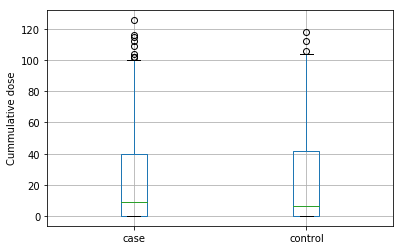

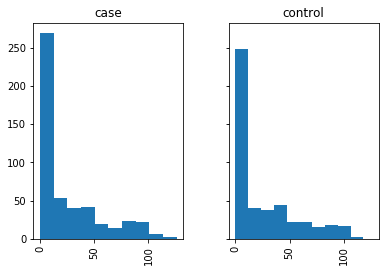

In [88]:
doses(df)

In [82]:
def ever_vs_never(df):
    """
    OR for ever vs never exposed
    """
    he = df.groupby(['case','participant_id']).final_jobcat.min().reset_index() # highest exposed
    he = he.groupby(['case','final_jobcat']).participant_id.count().reset_index()
    he.index = he.final_jobcat
    
    a = he[he['case'] == 1][['participant_id']]
    b = he[he['case'] == 0][['participant_id']]
    c = pd.concat([a,b], axis=1)
    c.columns = ['cases', 'controls']
    
    ever = c.iloc[0:5][['cases', 'controls']].sum()
    ever.name = 'ever'
    never = c.iloc[5:][['cases', 'controls']].sum()
    never.name = 'never'
    evn = pd.concat([ever, never], axis=1).transpose()
    evn['odds ratio'] = (evn['cases'].astype(float) / evn['controls'].astype(float)) \
                        / (evn.loc['never']['cases'].astype(float) / evn.loc['never']['controls'].astype(float))
        
    oddsratio, pvalue = stats.fisher_exact([evn['cases'].values, evn['controls'].values])
    evn['p-value'] = pvalue
    print(evn)
    return evn

def bycat(df):
    """
    OR by cat of exposure
    """
    he = df.groupby(['case','participant_id']).final_jobcat.min().reset_index() # highest exposed
    he = he.groupby(['case','final_jobcat']).participant_id.count().reset_index()
    he.index = he.final_jobcat
    
    a = he[he['case'] == 1][['participant_id']]
    b = he[he['case'] == 0][['participant_id']]
    c = pd.concat([a,b], axis=1)
    c.columns = ['cases', 'controls']
    c.index = jobgroups.values()
    Construction = c.iloc[1] + c.iloc[2] + c.iloc[3]
    Construction.name = 'Construction'
    c = c.append(Construction)
    c['odds ratio'] = (c['cases'].astype(float) / c['controls'].astype(float)) \
                        / (c.iloc[6]['cases'].astype(float) / c.iloc[6]['controls'].astype(float))
        
    odds = []
    p = []
    for cat in range(len(c)):
        t = c.iloc[[cat,6]]
        oddsratio, pvalue = stats.fisher_exact([t['cases'].values, t['controls'].values])
        odds.append(oddsratio)
        p.append(pvalue)
    
    c['p-value'] = p
    
    print(c.iloc[[0,7,4,5,6]])
    print('\n')
    print(c.iloc[[0,1,2,3,4,5,6]])
    
    return c 

def fibremlyearsbypt(df):
    """
    takes a df with fibre ml years
    """
    df = add_fibre_ml_years(df)
    df.case = df.case.replace(1,'case')
    df.case = df.case.replace(0,'control')
    fml_asb_exp = df.groupby(['case', 'participant_id'])['fibre/ml exposure'].sum().reset_index()
    ax = fml_asb_exp[fml_asb_exp['fibre/ml exposure'] > 0].boxplot(column='fibre/ml exposure', by='case')
    ax.set_xlabel("")
    ax.set_ylabel("fibre-ml.years")
    ax.get_figure().suptitle('') 
    ax.set_title("")
    print('\n# Fibre-ml statistics for participants with > 0 fibre ml years asbestos exposure')
    print(fml_asb_exp[fml_asb_exp['fibre/ml exposure'] > 0].groupby('case').describe())
    

/home/drcjar/anaconda3/envs/ipfjes/lib/python3.5/site-packages/ipykernel_launcher.py:64: FutureWarning: 'patient_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



# Fibre-ml statistics for participants with > 0 fibre ml years asbestos exposure
        fibre/ml exposure                                                \
                    count         mean          std       min       25%   
case                                                                      
case                125.0  1094.341885  5574.930849  0.000012  0.385084   
control             108.0   617.347699  3078.473749  0.000247  0.220548   

                                            
              50%        75%           max  
case                                        
case     6.857143  63.415525  50761.904762  
control  4.366321  57.360131  23785.714286  


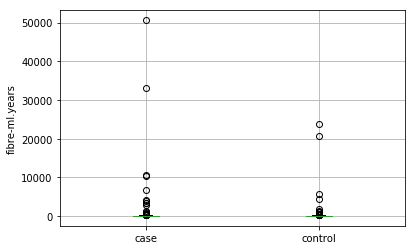

In [83]:
fibremlyearsbypt(df)

In [58]:
def proportion_of_exposed_fibre_ml_cats_bar_chart(df):
    """
    takes a df that contains fibre ml counts, sums them per participant, bins them and plots the result
    """
    df = add_fibre_ml_years(df)
    fml_asb_exp = df.groupby(['case', 'participant_id'])['fibre/ml exposure'].sum().reset_index()
    fml_asb_exp['fml_exposure_category'] = pd.cut(fml_asb_exp['fibre/ml exposure'], [0,0.01,0.1,1,10,100,1000,10000,100000], right=False, labels=['0-0.01',
    '0.01-0.1',
    '0.1-1',
    '1-10',
    '10-100',
    '100-1000',
    '1000-10000',
    '10000-100000'])
    
    fml_asb_exp = fml_asb_exp[fml_asb_exp['fibre/ml exposure'] > 0]
    print(fml_asb_exp['participant_id'].nunique())

    case_counts = fml_asb_exp[fml_asb_exp['case'] == 1].fml_exposure_category.value_counts(normalize=True).values
    control_counts = fml_asb_exp[fml_asb_exp['case'] == 0].fml_exposure_category.value_counts(normalize=True).values

    ind = np.arange(len(case_counts))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width/2, case_counts, width,
                color='IndianRed', label='cases')
    rects2 = ax.bar(ind + width/2, control_counts, width, 
                color='SkyBlue', label='controls')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('proportion of total')
    ax.set_xlabel('fibre-ml.years')

#   ax.set_title('Proportion of exposed particpants in fibre-ml.year categories of exposure')
    ax.set_xticks(ind)
    ax.set_xticklabels(('0-0.01',
    '0.01-0.1',
    '0.1-1',
    '1-10',
    '10-100',
    '100-1000',
    '1000-10000',
    '10000-100000'), rotation = 45, ha="right")
    ax.legend()
    plt.show()
    
def oddsratio_metal(df):
    """
    odds ratio for metal, exposed defined as word metal appearing in a job task
    """
    exposedany = df.groupby(level='patient_id').exposed_metal.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').exposed_metal.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)

def oddsratio_wood(df):
    """
    odds ratio for wood, exposed defined as word wood appearing in a job task
    """
    exposedany = df.groupby(level='patient_id').exposed_wood.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').exposed_wood.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)

/home/drcjar/anaconda3/envs/ipfjes/lib/python3.5/site-packages/ipykernel_launcher.py:169: FutureWarning: 'patient_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


233


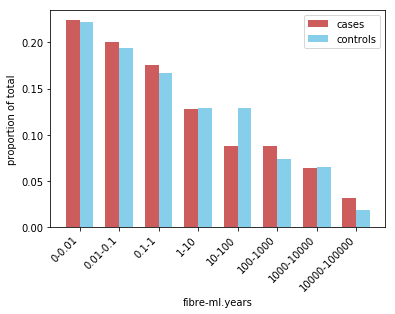

In [59]:
proportion_of_exposed_fibre_ml_cats_bar_chart(df)

In [37]:
def oddsratio_stone(df):
    """
     odds ratio for stone, exposed defined as word stone or silica appearing in a job task
    """
    exposedany = df.groupby(level='patient_id').exposed_stone.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').exposed_stone.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)
    
    
def oddsratio_farm(df):
    """
     odds ratio for farm, exposed defined as word farm appearing in a job task
    """
    exposedany = df.groupby(level='patient_id').exposed_farm.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').exposed_farm.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)

def oddsratio_asbestos_deprecated(df):
    """
    odds ratio for asbestos, exposed defined as word asbestos appearing in a job task
    """
    exposedany = df.groupby(level='patient_id').exposed_asbestos.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').exposed_asbestos.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)
    
def oddsratio_asbestos_short_list(df):
    """
    odds ratio using ever exposed defined as having a job that appears using peto short list (Table 2.3.1)
    """
    exposedany = df.groupby(level='patient_id').peto_shortlist.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').peto_shortlist.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)

def oddsratio_asbestos_long_list(df):
    """
    odds ratio using ever exposed defined as having a job that appears using peto long list (Table 2.3.2)
    """
    exposedany = df.groupby(level='patient_id').exposed.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').exposed.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)

def oddsratio_smoking(df):
    """
    calculates odds ratio for smoking from df. note is 
    """
    exposedany = df.groupby(level='patient_id').ever_smoked.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').ever_smoked.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)
    

def comorbidities():
    """
    Print information about comorbidities for cases and controls
    """
    como = ddf['ipfjes_pastmedicalhistory'].loc[:,['episode_id', 'condition_ft', 'details', 'condition_fk_id']]
    dis_lookup = ddf['opal_condition'][['id', 'name']]
    dis_lookup.index = dis_lookup['id']
    dis_lookup = dis_lookup['name'].to_dict()
    como = como.replace('', np.nan)
    como['cond'] = como['condition_fk_id'].map(lambda x: dis_lookup.get(x))
    como.condition_ft.fillna(como.cond, inplace=True)
    del como['cond']
    pt_lookup = ddf['ipfjes_studyparticipantdetails'].loc[:,['episode_id', 'participant_type']].copy()
    pt_lookup.index = pt_lookup['episode_id']
    pt_lookup = pt_lookup['participant_type'].to_dict()
    como['case'] = como['episode_id'].map(lambda x: pt_lookup.get(x)).copy()
    como.to_csv('comorbidities.csv')

    print('\n')
    print('top 10 comorbidites for cases (relative frequency)\n')
    print(como[como['case'] == 'case'].condition_ft.value_counts(normalize=True)[:10])
    print('\n')
    print('top 10 comorbidites for controls (relative frequency)\n')
    print(como[como['case'] == 'control'].condition_ft.value_counts(normalize=True)[:10])
    print('\n')

In [38]:
def oddsratio_pmr_cutoff(df, cutoff):
    """
     odds ratio for stone, exposed defined as word stone or silica appearing in a job task
    """
    df.loc[~df.index.isin(df[df['meso_pmr'] >= cutoff].groupby(level='patient_id').meso_pmr.any().index), 'meso_pmr'] = False
    df.loc[df.index.isin(df[df['meso_pmr'] > cutoff].groupby(level='patient_id').meso_pmr.any().index), 'meso_pmr'] = True

    a = df.loc[~df.index.isin(df[df['meso_pmr'] >= cutoff].groupby(level='patient_id').meso_pmr.any().index), 'meso_pmr'].to_frame()
    b = df[df['meso_pmr'] > cutoff].groupby(level='patient_id').meso_pmr.any().to_frame()

    exposedany = pd.concat([a,b])

    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').meso_pmr.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)

In [39]:
cutoff = 100

In [40]:
df.loc[df.meso_pmr >= cutoff, 'meso_pmr_cutoff'] = True
df.loc[df.meso_pmr < cutoff, 'meso_pmr_cutoff'] = False

In [41]:
df.index = df.patient_id

In [42]:
def odds_ratio_meso_pmr_cutoff(df, cutoff):
    """
    odds ratio for stone, exposed defined as word stone or silica appearing in a job task
    """
    df.loc[df.meso_pmr >= cutoff, 'meso_pmr_cutoff'] = True
    df.loc[df.meso_pmr < cutoff, 'meso_pmr_cutoff'] = False
    df.case = df.case.replace('case', 1)
    df.case = df.case.replace('control', 0)
    exposedany = df.groupby(level='patient_id').meso_pmr_cutoff.any().to_frame()
    casestatus = df.drop_duplicates(subset='patient_id').case.to_frame()
    summarydf = exposedany.merge(casestatus, right_index=True, left_index=True)
    table = summarydf.groupby('case').meso_pmr_cutoff.value_counts(sort=False).values
    table = ([[table[0], table[2]], [table[1], table[3]]])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)

In [43]:
odds_ratio_meso_pmr_cutoff(df, 100)

OddsR:  0.9511928953112064 p-Value: 0.733984256837229


In [44]:
odds_ratio_meso_pmr_cutoff(df, 200)

OddsR:  1.2170542635658914 p-Value: 0.17986450333365536


In [45]:
odds_ratio_meso_pmr_cutoff(df, 300)

OddsR:  1.4756380510440836 p-Value: 0.07823866493843908


In [46]:
odds_ratio_meso_pmr_cutoff(df, 400)

OddsR:  2.2954356846473027 p-Value: 0.14281703053506317


In [47]:
df.groupby('case').meso_pmr.describe()

,count,mean,std,min,25%,50%,75%,max
case,,,,,,,,
0,1990.0,93.125327,77.135691,0.0,48.25,65.91,113.79,528.18
1,2309.0,97.948138,84.857118,0.0,48.25,65.46,120.50,528.18


In [48]:
def resultsf(df):
    """
    prints (hopefully) interesting study results
    """
    df.case = df.case.replace('case', 1)
    df.case = df.case.replace('control', 0)
    
    print("Computing {} rows of data (each row is a job)\n".format(len(df)))
    print('We have all the cases. Number of controls we need to recruit:\n')
    print((460 - len(df[df['case'] == 0].patient_id.unique()) - len(set(notepisodes()) - set(list(removed()['episode_id'].values))) - 1))
    
    print('\n# Number of participants interviewed\n')
    print (df.patient_id.nunique())
    
    print('\n# Number of participants waiting for an interview\n')
    print (len(set(notepisodes()) - set(list(removed()['episode_id'].values))))
    
    print('\n# Number of participants temporarily removed for being from Isle of Man\n')
    print('3')

    rm = removed() # currently breaks because of copying error
    print("\n# Number of participants removed")
    print("\n")
    print(len(rm))
    print("\n")
    print(rm.groupby('case').participant_id.count())
    print("\n")
    print(rm.groupby('case').reason.value_counts())
    print("\n")
    print(rm[['participant_id', 'case', 'reason']].sort_values(by='participant_id'))
    print("\n")
    
    print('\n# Number of cases and controls\n')
    print (df.groupby('case').patient_id.nunique()) # group by participant type and count number of unique patient ids
    
    print('\n# Age breakdown\n')
    print (df.drop_duplicates(subset='patient_id').groupby('case').age.describe())
    # df.boxplot(by='case', column='age')
    
    print('\n# Age matching\n')
    print(df.drop_duplicates(subset='patient_id').groupby('case').agegroup.value_counts(sort=False).unstack())

    print('\n# Ethnicity\n')
    
    print (df.drop_duplicates(subset='patient_id').groupby('case').ethnicity.value_counts())
    # drop duplicate patient ids (they exist because our main table has a row for each job), count ethnicities

    print('\n# Ever smoked\n')
    print (df.drop_duplicates(subset='patient_id').groupby('case').ever_smoked.value_counts())
    # drop duplicate patient ids (they exist because our main table has a row for each job), count ever smokers

    print('\n# Ever smoked(%)\n')
    print(df[df['ever_smoked'] == True].drop_duplicates(subset='patient_id').groupby('case').ever_smoked.value_counts() / df.groupby('case').patient_id.nunique() * 100)

    print('\n# Current smoker\n')
    print (df.drop_duplicates(subset='patient_id').groupby('case').current_smoker.value_counts())
    # drop duplicate patient ids (they exist because our main table has a row for each job), count ever smokers

    print('\n# Current smoker(%)\n')
    print(df[df['current_smoker'] == True].drop_duplicates(subset='patient_id').groupby('case').current_smoker.value_counts() / df.groupby('case').patient_id.nunique() * 100)

    print('\n# Pack-age (mean)\n')
    print(df.drop_duplicates(subset='patient_id').groupby('case').packyrs.mean())

    print('\n# Social class (based on all jobs)\n')
    print (df.groupby('case').ssec.describe())
    # this is calculated based on job soc; currently is looking at all jobs which probably isnt desirable

    highest_ssec(df)
    # same as Social class above but based on lowest social code job (which is how is normally done)
    
    jobstats(df)
    print("\n# mean mesothelioma PMR (91-2000) for all jobs for cases and controls at study level\n")
    print(df.groupby(['case']).meso_pmr.mean())
    print("\n# mean mesothelioma PMR (91-2000) for all jobs for cases and controls at participant level\n")
    print(df.groupby(['case', 'participant_id']).meso_pmr.mean().groupby('case').mean())
    print('\n# Asbestos exposed job(%) of all jobs (according to Coggon)\n')
    print(df[df.soc2000.isin(ae.soc2000)].groupby('case').patient_id.count() / df.groupby('case').patient_id.count() * 100)
    # this is calculated based on job soc; currently is looking at all jobs which probably isnt desirable

    print('\n# Asbestos exposed job(%) of all jobs(according to Peto) using short list (Table 2.3.1)\n')
    print(df[df.soc90.isin(ae2.soc1990)].groupby('case').patient_id.count() / df.groupby('case').patient_id.count() * 100)
    # this is calculated based on job soc; currently is looking at all jobs which probably isnt desirable

    print('\n# Patients with at least 1 asbestos exposed job(%) (according to Coggon)\n')
    print(df[df.soc2000.isin(ae.soc2000)].drop_duplicates(subset='patient_id').groupby('case').patient_id.count() / df.groupby('case').patient_id.nunique() * 100)

    print('\n# Patients with at least 1 asbestos exposed job(%) (according to Peto using short list (Table 2.3.1))\n')
    print(df[df.soc90.isin(ae2.soc1990)].drop_duplicates(subset='patient_id').groupby('case').patient_id.count() / df.groupby('case').patient_id.nunique() * 100)

    print('\n# Number of jobs in each Peto category of exposure (Table 2.3.2)\n')
    print(df.groupby(['case']).jobcatname.value_counts())
    
    print('\n# Percent of jobs in each Peto category of exposure (Table 2.3.2)\n')
    print(df.groupby(['case']).jobcatname.value_counts(normalize=True))
    
    proportion_high_med(df)
    
    df.groupby(['case']).jobcatname.value_counts(normalize=True).plot(kind='bar')
    
    print('\n# "Dose" using Peto categories of exposure (Table 2.3.2)\n')
    print('\n dose is calculated at participant level by multiplying age in job with job score')
    print('\nscoring system used e.g office based, category 5, scores 0\n')
    print(exposed)
    print('\n')
    print(doses(df))
    
    print('\n# OR for "ever" vs "never" for Peto categories of exposure (Table 2.3.2)\n')
    print('"ever" defined as ever having job that scores > 0\n')
    ever_vs_never(df)
    
    print('\n# OR for Peto categories of exposure (Table 2.3.2)\n')
    bycat(df)
    
    asbestos_screening_responses(df)
    
    fibremlyearsbypt(df)
    
    proportion_of_exposed_fibre_ml_cats_bar_chart(df)
    print('\n# Odds ratio for smoking\n')
    print(oddsratio_smoking(df))
    print('\n# Odds ratio for wood exposure (exposed if word appears in job task description)\n')
    print(oddsratio_wood(df))
    print('\n# Odds ratio for metal exposure(exposed if word appears in job task description)\n')
    print(oddsratio_metal(df))
    print('\n# Odds ratio for stone exposure(exposed if word appears in job task description)\n')
    print(oddsratio_stone(df))
    print('\n# Odds ratio for farm exposure(exposed if word appears in job task description)\n')
    print(oddsratio_farm(df))
    print('\n# Odds ratio for asbestos exposure(exposed if word appears in job task description)\n')
    print(oddsratio_asbestos_deprecated(df))
    print('\n# Odds ratio for asbestos exposure exposed if ever have a job using short list (Table 2.3.1)\n')
    print(oddsratio_asbestos_short_list(df))
    print('\n# Odds ratio for asbestos exposure exposed if ever have medium or high risk job using long list (Table 2.3.2)\n')
    print(oddsratio_asbestos_long_list(df))
    
    
    print('\n# Distance from centre (by centre) in km\n')
    df['distfromcentre'] = df.apply(dist_from_centre, axis=1)
    print(df[~df['gp_coords'].isnull()].drop_duplicates(subset='patient_id').groupby(['centre','case']).distfromcentre.describe())

    print('\n# Distance from centre (study av) in km\n')
    print(df[~df['gp_coords'].isnull()].drop_duplicates(subset='patient_id').groupby(['case']).distfromcentre.mean())
    # figures don't look right
    
    print('\n# Comorbidities')
    comorbidities()
    
    print('\n# Use of drugs know to cause UIP\n')
    print('\nby cases (relative frequency)')
    print(df[df['case'] == 1].drop_duplicates(subset='patient_id')[['amiodarone', 'flecainade', 'nitrofurantoin', 'azathioprine',
       'gefitinib', 'ifosfamide', 'melphalan', 'rituximab']].any(axis=1).value_counts(normalize=True, ascending=True))
    print('\nby controls (relative frequency)')
    print(df[df['case'] == 0].drop_duplicates(subset='patient_id')[['amiodarone', 'flecainade', 'nitrofurantoin', 'azathioprine',
       'gefitinib', 'ifosfamide', 'melphalan', 'rituximab']].any(axis=1).value_counts(normalize=True, ascending=True))
    
    print('\n# Family history of scarring lung disease\n')
    print('by cases (relative frequency)')
    print(df[df['case'] == 1].drop_duplicates(subset='patient_id').fhx.value_counts(normalize=True, ascending=True))
    print('\nby controls (relative frequency)')
    print(df[df['case'] == 0].drop_duplicates(subset='patient_id').fhx.value_counts(normalize=True, ascending=True))

    print('\n# mMRC \n')
    print('\n mean mMRC dyspnoea score by participant type\n')
    print(df.drop_duplicates(subset='patient_id').groupby('case').mrc_score.mean())

    print('\n# Presenting complaints (% of cases with particular presenting complaint) \n')
    print((df[df['case'] == 1].drop_duplicates(subset='patient_id')[['pc_sob', 'pc_cough', 'pc_incidental']].sum()) / df[df['case'] == 1].drop_duplicates(subset='patient_id').patient_id.count() * 100)
    

/home/drcjar/anaconda3/envs/ipfjes/lib/python3.5/site-packages/ipykernel_launcher.py:169: FutureWarning: 'patient_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


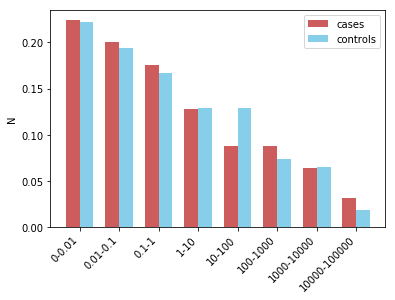

In [49]:
proportion_of_exposed_fibre_ml_cats_bar_chart(df)


In [ ]:
df[df.gp_coords.isnull()].patient_id.unique()

In [ ]:
resultsf(df)

In [ ]:
df[df.packyrs > 0].drop_duplicates(subset='patient_id').groupby('case').packyrs.describe()

In [ ]:
df[df.ever_smoked == True].drop_duplicates(subset='patient_id').patient_id.isin(~df[df.packyrs > 0].drop_duplicates(subset='patient_id').patient_id).value_counts()

In [ ]:
set(df[df.ever_smoked].drop_duplicates(subset='patient_id').patient_id)-set(df[df.packyrs > 0].drop_duplicates(subset='patient_id').patient_id)

In [ ]:
df[df.patient_id.isin([13, 55, 74, 119, 384, 546, 808])].to_csv('debuggo.csv')

In [ ]:
def make_n_of_cases_and_controls_the_same(df, n):
    """
    makes a random balanced sample
    """
    a = df[df['case'] == 1].drop_duplicates(subset='participant_id').sample(n=n, random_state=1).participant_id.values
    a = df[df.participant_id.isin(a)]
    b = df[df['case'] == 0].drop_duplicates(subset='participant_id').sample(n=n, random_state=1).participant_id.values
    b = df[df.participant_id.isin(b)]
    c = pd.concat([a,b])
    return c

In [ ]:
resultsf(make_n_of_cases_and_controls_the_same(df, 340))

In [ ]:
resultsf(df[df['end_year'].astype(int) < 1980].copy())  # sensitivity analysis

In [ ]:
resultsf(df[df['duration'].astype(int) >= 5].copy()) # sensitivity analysis

In [ ]:
resultsf(df[df['distfromcentre'] < 10].copy()) # sensitivity analysis

In [ ]:
resultsf(df[(df.case == 1) & (df.ct == "definite UIP")|(df.case == 0)].copy()) # sensitivity analysis

In [ ]:
df.groupby(['case','participant_id']).meso_pmr_dose.sum().reset_index()

In [ ]:
def flattenstudydf(df):
    """
    flattens study dataframe to be one participant per row
    """
    exposed = df.groupby(['case','participant_id']).exposed.any().reset_index()
    exps_stone = df.groupby(['case','participant_id']).exposed_stone.any().reset_index()
    exps_wood = df.groupby(['case','participant_id']).exposed_wood.any().reset_index()
    exps_metal = df.groupby(['case','participant_id']).exposed_metal.any().reset_index()
    exps_farm = df.groupby(['case','participant_id']).exposed_farm.any().reset_index()
    exps_asbestos = df.groupby(['case','participant_id']).exposed_asbestos.any().reset_index()
    exps_dose = df.groupby(['case','participant_id']).dose.sum().reset_index()
    ssec = df.groupby(['case','participant_id']).ssec.median().reset_index()
    fmls = add_fibre_ml_years(df)
    fmls = fmls.groupby(['case','participant_id'])['fibre/ml exposure'].sum().reset_index()
    lowest_peto_cat = df.groupby(['case','participant_id']).final_jobcat.min().reset_index()
    peto_shortlist = df.groupby(['case','participant_id'])['peto_shortlist'].any().reset_index()
    coggan_shortlist = df.groupby(['case','participant_id'])['coggan_shortlist'].any().reset_index()
    highest_pmr = df.groupby(['case','participant_id']).meso_pmr.max().reset_index()
    mean_pmr = df.groupby(['case','participant_id']).meso_pmr.mean().reset_index()
    meso_pmr_dose = df.groupby(['case','participant_id']).meso_pmr_dose.sum().reset_index()

    data_frames = [exposed, exps_stone, exps_wood, exps_metal, exps_farm, exps_asbestos, exps_dose, ssec, 
                   fmls, lowest_peto_cat, peto_shortlist, coggan_shortlist, mean_pmr, highest_pmr, meso_pmr_dose]
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['case','participant_id'],
                                                how='outer'), data_frames)
    
    df = df.drop_duplicates(subset='patient_id')
    df = df[['patient_id', 'case', 'dob', 'age', 'yob', 'agegroup', 'ethnicity',
       'ever_smoked', 'current_smoker', 'packyrs', 'participant_id', 'centre', 'gp_coords',
       'centre_coords', 'distfromcentre', 'ct', 'bx', 'fhx', 'amiodarone',
       'flecainade', 'nitrofurantoin', 'azathioprine', 'gefitinib',
       'ifosfamide', 'melphalan', 'rituximab', 'mrc0', 'mrc1', 'mrc2', 'mrc3',
       'mrc4', 'pc_sob', 'pc_cough', 'pc_incidental', 'pc_incidental_desc',
       'pc_other', 'comments', 'mrc_score']]
    
    df = pd.merge(df, df_merged, on=['case','participant_id'],
                                                how='outer')
    return df

In [ ]:
def rename_and_clean(df):
    """
    renames columns to be a bit more conventional and cleans data
    """
    assert len(df.columns) == len(['patient_id', 'case', 'dob', 'age', 'yob', 'agegroup', 'ethnicity',
       'ever_smoked', 'current_smoker', 'packyrs', 'participant_id', 'centre',
       'gp_coords', 'centre_coords', 'distfromcentre', 'ct', 'bx', 'fhx',
       'amiodarone', 'flecainade', 'nitrofurantoin', 'azathioprine',
       'gefitinib', 'ifosfamide', 'melphalan', 'rituximab', 'mrc0', 'mrc1',
       'mrc2', 'mrc3', 'mrc4', 'pc_sob', 'pc_cough', 'pc_incidental',
       'pc_incidental_desc', 'pc_other', 'comments', 'mrc_score', 'exposed',
       'exposed_stone', 'exposed_wood', 'exposed_metal', 'exposed_farm',
       'exposed_asbestos', 'dose', 'ssec', 'fibre/ml exposure', 'final_jobcat',
       'peto_shortlist', 'coggan_shortlist', 'meso_pmr_x', 'meso_pmr_y','meso_pmr_dose'])
    
    df.columns = ['ipfjes_id', 'case', 'dob', 'age', 'yob', 'agegroup', 'ethnicity',
       'ever_smoked', 'current_smoker', 'packyrs', 'participant_id', 'centre',
       'gp_coords', 'centre_coords', 'distfromcentre', 'ct', 'bx', 'fhx',
       'amiodarone', 'flecainade', 'nitrofurantoin', 'azathioprine',
       'gefitinib', 'ifosfamide', 'melphalan', 'rituximab', 'mrc0', 'mrc1',
       'mrc2', 'mrc3', 'mrc4', 'pc_sob', 'pc_cough', 'pc_incidental',
       'pc_incidental_desc', 'pc_other', 'comments', 'mrc_score', 'peto_exposed',
       'exposed_stone', 'exposed_wood', 'exposed_metal', 'exposed_farm',
       'exposed_asbestos', 'peto_dose', 'median_ssec', 'fibre_ml_exposure', 'lowest_peto_cat',
       'peto_shortlist', 'coggan_shortlist', 'mean_pmr', 'highest_pmr','meso_pmr_dose']
    
    df.case = df.case.replace('case', 1)
    df.case = df.case.replace('control', 0)
    
    agecat = {"40 to 44":0, "50 to 54":1, "55 to 59":2, "60 to 64":3, "65 to 69":4, "70 to 74":5, "75 to 79":6, "80 to 84":7, "85 to 90":8, "90 to 94":9}
    ethcat = {'White':0, 'Asian / Asian British':1, 'Arab':2,
           'Mixed / Multiple ethnic groups':3, 'Other ethnic group':4,
           'Black / African/ Caribbean/ Black British':5}
    ctcat = {'definite UIP':2, 'possible UIP':1, 'no CT':0, 'other':0, None:0}
    bxcat = {'no Biopsy':0, 'definite UIP':1, None:0}
             
    df['agecat'] = df.agegroup.map(agecat)
    df['ethcat'] = df.ethnicity.map(ethcat)
    df['ctcat'] = df.ct.map(ctcat)
    df['bxcat'] = df.bx.map(bxcat)
    
    df['packyrs'] = df['packyrs'].fillna(0).astype(int)
    df['ever_smoked'] = df['ever_smoked'].fillna(0).astype(int)
    df['current_smoker'] = df['current_smoker'].fillna(0).astype(int)
    df['peto_exposed'] = df['peto_exposed'].fillna(0).astype(int)
    df['exposed_stone'] = df['exposed_stone'].fillna(0).astype(int)
    df['exposed_wood'] = df['exposed_wood'].fillna(0).astype(int)
    df['exposed_metal'] = df['exposed_metal'].fillna(0).astype(int)
    df['exposed_farm'] = df['exposed_farm'].fillna(0).astype(int)
    df['exposed_asbestos'] = df['exposed_asbestos'].fillna(0).astype(int)
    df['fhx'] = df['fhx'].fillna(0).astype(int)
    df['pc_sob'] = df['pc_sob'].fillna(0).astype(int)
    df['pc_cough'] = df['pc_cough'].fillna(0).astype(int)
    centre_id = pd.read_csv('ipfjes-centre-ids.csv', index_col='Centre ID')
    centre_lookup = centre_id['Organisation'].to_dict()
    df['centre_name'] = df['centre'].map(lambda x: centre_lookup.get(x)).copy()
    dummy = pd.get_dummies(df['centre_name'])
    df = pd.concat([df, dummy], axis=1)
    dummy = pd.get_dummies(df['ethnicity'])
    df = pd.concat([df, dummy], axis=1)
    dummy = pd.get_dummies(df['ct'])
    df = pd.concat([df, dummy], axis=1)
    # dummy = pd.get_dummies(df['bx'])
    # df = pd.concat([df, dummy], axis=1)
    df['peto_shortlist'] = df['peto_shortlist'].fillna(0).astype(int)
    df['coggan_shortlist'] = df['coggan_shortlist'].fillna(0).astype(int)
    # if have never smoked can set null current smoker to 0
    df.loc[(df['current_smoker'].isnull()) & (df['ever_smoked'] == 0), 'current_smoker'] = 0 
    
    df.loc[:,['amiodarone', 'flecainade', 'nitrofurantoin', 'azathioprine',
       'gefitinib', 'ifosfamide', 'melphalan', 'rituximab', 'mrc0', 'mrc1',
       'mrc2', 'mrc3', 'mrc4']] = df.loc[:,['amiodarone', 'flecainade', 'nitrofurantoin', 'azathioprine',
       'gefitinib', 'ifosfamide', 'melphalan', 'rituximab', 'mrc0', 'mrc1',
       'mrc2', 'mrc3', 'mrc4']].fillna(0).astype(int)
    df.loc[:,'ever_drug_exposed'] = df[['amiodarone', 'flecainade', 'nitrofurantoin', 'azathioprine',
           'gefitinib', 'ifosfamide', 'melphalan', 'rituximab']].any(axis=1).astype(int)
    return df

In [ ]:
df.groupby('case').exposed_metal.value_counts().sum()

In [ ]:
df.columns

In [ ]:
# sens analysis
df1 = rename_and_clean(flattenstudydf(df[df['end_year'].astype(int) < 1980].copy()))
df1.to_csv('flat_dataframe_1980.csv', index=False) # dataframe flattened to participant level

df1 = rename_and_clean(flattenstudydf(df[df['duration'].astype(int) >= 5].copy()))
df1.to_csv('flat_dataframe_5_years_or_more.csv', index=False) # dataframe flattened to participant level

df1 = rename_and_clean(flattenstudydf(df[df['distfromcentre'] < 10].copy()))
df1.to_csv('flat_dataframe_10_km_less.csv', index=False) # dataframe flattened to participant level

df1 = rename_and_clean(flattenstudydf(df[df['end_year'].astype(int) < (df.yob.astype(int) + 45)].copy()))
df1.to_csv('jobs_before_45.csv', index=False) # dataframe flattened to participant level

df = rename_and_clean(flattenstudydf(df))
df.to_csv('flat_dataframe.csv', index=False) # dataframe flattened to participant level

In [ ]:
# data for sharing # 
# jobs_dataframe.csv
# job_tasks_dataframe.csv
# flat_dataframe.csv

In [ ]:
df.head()

In [ ]:
df[df['case'] == 1]['ct'].value_counts()

In [ ]:
df[(df['case'] == 1) & (df['ct'] == 'no CT')].ipfjes_id.values

In [ ]:
df[df['case'] == 1]['bx'].value_counts()

In [ ]:
"""
Comments summary
"""

print('bird contact in comments \n')
print(df[df[~df.comments.isnull()]['comments'].str.contains('aviary|pigeon|budgerigar')].case.value_counts(sort=False))


print('\nmemory probs in comments \n')
print(df[df[~df.comments.isnull()]['comments'].str.contains('memory')].case.value_counts(sort=False))

print('\ndid not do interview themselves in comments \n')
print(df[df[~df.comments.isnull()]['comments'].str.contains('wife|daughter')].case.value_counts(sort=False))

In [ ]:
df.groupby('case').exposed_wood.value_counts()

In [ ]:
df.groupby('case').exposed_wood.value_counts(normalize=True)

In [ ]:
df.groupby('case').exposed_metal.value_counts()

In [ ]:
df.groupby('case').exposed_metal.value_counts(normalize=True)

In [ ]:
df.groupby('case').exposed_stone.value_counts()

In [ ]:
df.groupby('case').exposed_stone.value_counts(normalize=True)

In [ ]:
df[(df['exposed_stone'] == 1) & (df['exposed_metal'] == 1) & (df['exposed_wood'] == 1)]
# one case and one control exposed to all three

In [ ]:
df[(df['exposed_stone'] == 1) & (df['exposed_metal'] == 1)].case.value_counts()
# 8 cases exposed to stone and metal. 1 control exposed to stone and metal. 

In [ ]:
df[(df['exposed_stone'] == 1) & (df['exposed_wood'] == 1)].case.value_counts()


In [ ]:
df[(df['exposed_metal'] == 1) & (df['exposed_wood'] == 1)].case.value_counts()


In [ ]:
df[(df['exposed_stone'] == 1) & (df['exposed_metal'] == 1)].ipfjes_id

In [ ]:
df[(df['exposed_stone'] == 1) | (df['exposed_metal'] == 1) | (df['exposed_wood'] == 1)].case.value_counts()

In [ ]:
df[(df['exposed_stone'] == 1) | (df['exposed_metal'] == 1) | (df['exposed_wood'] == 1)].case.value_counts(normalize=True)

In [ ]:
df.case.value_counts()

In [ ]:
df['exposed_smw'] = 0
# stone, metal, wood

In [ ]:
df.loc[(df['exposed_stone'] == 1) | (df['exposed_metal'] == 1) | (df['exposed_wood'] == 1), 'exposed_smw'] = 1

In [ ]:
df['exposed_smw'].value_counts()

In [ ]:
df['exposed_smw'].value_counts(normalize=True)

In [ ]:
df.groupby('case')['peto_exposed'].value_counts(normalize=True)

In [ ]:
df.groupby('case')['exposed_smw'].value_counts(normalize=True)

In [ ]:
df[df['fibre_ml_exposure'] > 0].case.value_counts(sort=False)

In [ ]:
df[(df.fibre_ml_exposure < 5) & (df.fibre_ml_exposure > 0)].case.value_counts(sort=False)

In [ ]:
df[(df.fibre_ml_exposure >= 5) & (df.fibre_ml_exposure < 10)].case.value_counts(sort=False)

In [ ]:
df[(df.fibre_ml_exposure >= 10) & (df.fibre_ml_exposure < 15)].case.value_counts(sort=False)

In [ ]:
df[(df.fibre_ml_exposure >= 15) & (df.fibre_ml_exposure < 20)].case.value_counts(sort=False)

In [ ]:
df[(df.fibre_ml_exposure >= 20) & (df.fibre_ml_exposure < 25)].case.value_counts(sort=False)

In [ ]:
df[df.fibre_ml_exposure > 25].case.value_counts(sort=False)

In [ ]:
df[(df['exposed_stone'] == 1) & (df['exposed_asbestos'] == 1)].ipfjes_id

df. columns

In [ ]:
df.columns

In [ ]:
df.groupby('case').median_ssec.value_counts(sort=False).unstack().transpose()

In [ ]:
df.groupby('case').bx.value_counts(sort=False)

In [ ]:
df[(df['case'] == 0) & (df['ct'] == 'definite UIP')]

In [ ]:
df.groupby('case').pc_other.value_counts()

In [ ]:
df.columns

In [ ]:
df.groupby('case').centre.value_counts(sort=False).unstack().transpose()

In [ ]:
df[df['case'] == 0].yob.astype(int).describe()

In [ ]:
df[df['case'] == 1].yob.astype(int).describe()

In [ ]:
df[df['case'] == 1].pc_sob.value_counts()

In [ ]:
df[df['case'] == 1].pc_cough.value_counts()

In [ ]:
df[(df['case'] == 1) & (df['pc_cough'] == 1) &  (df['pc_sob'] == 1) ].pc_sob.value_counts()

In [ ]:
df.groupby('case')['ever_drug_exposed'].value_counts()

In [ ]:
df.groupby('case')['ever_drug_exposed'].value_counts(normalize=True)

In [ ]:
pts_with_RA = [ 35,  90, 172, 223, 271, 272, 306, 304, 314, 368, 375, 377, 404,
       416, 435, 465, 526, 532, 590, 612, 623, 629, 691, 695, 743, 966,
       954]

In [ ]:
df[df['exposed_stone'] == 1].ipfjes_id.isin(pts_with_RA).value_counts() # no 

In [ ]:
df[df.fibre_ml_exposure > 25].centre_name.value_counts()

In [ ]:
df[(df.fibre_ml_exposure > 25) & (df.case == 1)].centre_name.value_counts()

In [ ]:
df[(df.fibre_ml_exposure > 25) & (df.case == 0)].centre_name.value_counts()

In [ ]:
df[(df.fibre_ml_exposure > 25) & (df.case == 1) & (df.centre_name == 'Heart of England NHS Foundation Trust')]

In [ ]:
df[(df.fibre_ml_exposure > 25) & (df.case == 1) & (df.centre_name == 'Heart of England NHS Foundation Trust')].to_csv('birmingham_flat.csv', index=False)

In [ ]:
df1 = pd.read_csv('jobs_dataframe.csv')
df2 = pd.read_csv('job_tasks_dataframe.csv')

In [ ]:
len(df2[df2['fibre/ml exposure'] > 0])

In [ ]:
df1[df1.patient_id.isin([142, 480])].to_csv('birmingham_jobs.csv', index=False)

In [ ]:
df2[df2.patient_id.isin([142, 480])].to_csv('birmingham_asbestos_exposure.csv', index=False)

In [ ]:
df1[df1.patient_id.isin(df[df.fibre_ml_exposure > 25].ipfjes_id.values)]

In [ ]:
df1.columns

In [ ]:
df3 = df2[df2.patient_id.isin(df[df.fibre_ml_exposure > 25].ipfjes_id.values)]

In [ ]:
df3.columns

In [ ]:
df3[(df3['fibre/ml exposure'] > 25) * (df3.final_jobcat == 3)]

In [ ]:
df3[df3['fibre/ml exposure'] > 25].soc_job_ft.value_counts()

In [ ]:
df1[df1.patient_id.isin(df[df.fibre_ml_exposure > 25].ipfjes_id.values)].to_csv('over25s.csv')

In [ ]:
df2[df2.patient_id.isin(df[df.fibre_ml_exposure > 25].ipfjes_id.values)].to_csv('over25s2.csv')

In [ ]:
df4 = df2[df2.patient_id.isin(df[df.fibre_ml_exposure > 25].ipfjes_id.values)]

In [ ]:
df[df.fibre_ml_exposure > 25].ipfjes_id.nunique()

In [ ]:
df4[df4['fibre/ml exposure'] > 25].patient_id.nunique()

In [ ]:
# 67 of 76 participants with > 25 fibre ml year exposure estimates had a least one single job task with fibre ml > 25

In [ ]:
df4[(df4['fibre/ml exposure'] > 25)].final_jobcat.value_counts()

In [ ]:
df4.final_jobcat.value_counts().sum()

In [ ]:
df4[(df4['fibre/ml exposure'] > 25) & (df4['final_jobcat'] == 5)].to_csv('lowhigh25s.csv')

In [ ]:
# 7 out of 10 'low highs' were far field exposures

In [ ]:
df = pd.read_csv('flat_dataframe.csv')

In [ ]:
df.groupby('case').distfromcentre.mean()

In [ ]:
import seaborn as sns; sns.set(color_codes=True)

df.boxplot(column='distfromcentre', by='case', vert=False, figsize=(5,5))

In [ ]:
df.boxplot(column='distfromcentre', by='peto_exposed', vert=False, figsize=(5,5)) # being exposed is assoc with being closer to centre

In [ ]:
import scipy.stats as stats

stats.pearsonr(df['case'], df['distfromcentre'])

In [ ]:
stats.pearsonr(df['distfromcentre'], df['peto_exposed'])

In [ ]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [ ]:
pearsonr_ci(df['distfromcentre'],df['case'],alpha=0.05)

In [ ]:
pearsonr_ci(df['distfromcentre'],df['peto_exposed'],alpha=0.05)

In [ ]:
pearsonr_ci(df['mrc_score'],df['case'],alpha=0.05)

In [ ]:
df[df.fibre_ml_exposure > 25].mrc_score.describe()

In [ ]:
df[df.fibre_ml_exposure <= 25].mrc_score.describe()

In [ ]:
df[(df.fibre_ml_exposure > 25) & (df.case == 1)].mrc_score.describe()

In [ ]:
df[(df.fibre_ml_exposure <= 25) & (df.case == 1)].mrc_score.describe()

In [ ]:
df.groupby('ever_smoked').mrc_score.describe()

In [ ]:
something on folk with more asb exposure being more sob?

In [ ]:
something on folk with more asb exposure being more sob

In [ ]:
something on folk with more asb exposure being more sob

In [ ]:
something on folk with more asb exposure being more sob

In [ ]:
# something on folk with more asb exposure being more sob

In [ ]:
df.columns

In [ ]:
df['fibre_ml_exposure_over_00'] = df.fibre_ml_exposure > 200

In [ ]:
df.groupby('case')['fibre_ml_exposure_over_200'].value_counts()

In [ ]:
df.groupby('case')['fibre_ml_exposure_over_200'].value_counts(normalize=True)

In [ ]:
len(df)